# Albumentations Modeling Notebook

## Importing Packages

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
from utils import *


## Augmentation through ImageDataGenerator

In [70]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

train_folder = '../split/train_imb'
val_folder = '../split/val'
test_folder = '../split/test2'

train_generator = train_datagen.flow_from_directory(train_folder, 
                                                    target_size=(224, 224), 
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    seed = 42)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       target_size=(224, 224),
                                                                       batch_size = 16,
                                                                       class_mode = 'binary',
                                                                       seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        target_size = (224, 224),
                                                                        batch_size = 1,
                                                                        class_mode = 'binary',
                                                                        shuffle=False)

Found 26500 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [71]:
def create_model(input_shape):
    return models.Sequential([
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Flatten(),
        layers.Dense(units=4096, activation='relu'),
        layers.Dense(units=1, activation='sigmoid')
        ])
        # sigmoid also

model = create_model((224, 224, 3))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [72]:
filepath = '../models/CNN_v1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = train_generator,
                              epochs = 10,
                              steps_per_epoch = 20,
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 64.1351 - accuracy: 0.8696 - precision_6: 0.9638 - recall_6: 0.8983 - auc_12: 0.5127 - auc_13: 0.9695 

KeyboardInterrupt: 

## Augmentation through Albumentations

In [61]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 244),
        batch_size = 32,
        class_mode = 'binary',
        seed = 42)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 3830 images belonging to 2 classes.
Found 678 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [ ]:
X_tr, y_tr = next(train_generator)
X_val, y_val = next(val_generator)
X_tt, y_tt = next(test_generator)

## CNN Model

This model was inspired by the VGG16 model which was the only one that seemed to produce any normal metrics

In [62]:
def create_model(input_shape):
    return models.Sequential([
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Flatten(),
        layers.Dense(units=4096, activation='relu'),
        layers.Dense(units=1, activation='sigmoid')
        ])

model = create_model((224, 224, 3))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')],
              run_eagerly = True)


In [64]:
filepath = '../models/CNN.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = train_generator,
                              epochs = 10,
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator,
                              steps_per_epoch = len(train_generator)
                              validation_steps = len(val_generator))

Epoch 1/10
14/14 [==============================] - 654s 48s/step - loss: 68.9850 - accuracy: 0.6719 - precision_5: 0.7645 - recall_5: 0.7621 - auc_10: 0.6180 - auc_11: 0.7572 - val_loss: 1416.7845 - val_accuracy: 0.9587 - val_precision_5: 0.9587 - val_recall_5: 1.0000 - val_auc_10: 0.5000 - val_auc_11: 0.9587
Epoch 2/10
14/14 [==============================] - 660s 49s/step - loss: 8.3772 - accuracy: 0.7455 - precision_5: 0.8349 - recall_5: 0.8092 - auc_10: 0.7450 - auc_11: 0.8579 - val_loss: 1751.4963 - val_accuracy: 0.0413 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_10: 0.5000 - val_auc_11: 0.9587
Epoch 3/10
14/14 [==============================] - 801s 59s/step - loss: 1.3722 - accuracy: 0.7900 - precision_5: 0.8377 - recall_5: 0.8547 - auc_10: 0.8458 - auc_11: 0.8958 - val_loss: 7.6726 - val_accuracy: 0.9513 - val_precision_5: 0.9584 - val_recall_5: 0.9923 - val_auc_10: 0.4962 - val_auc_11: 0.9584
Epoch 4/10
14/14 [==============================] - 943s 69s/

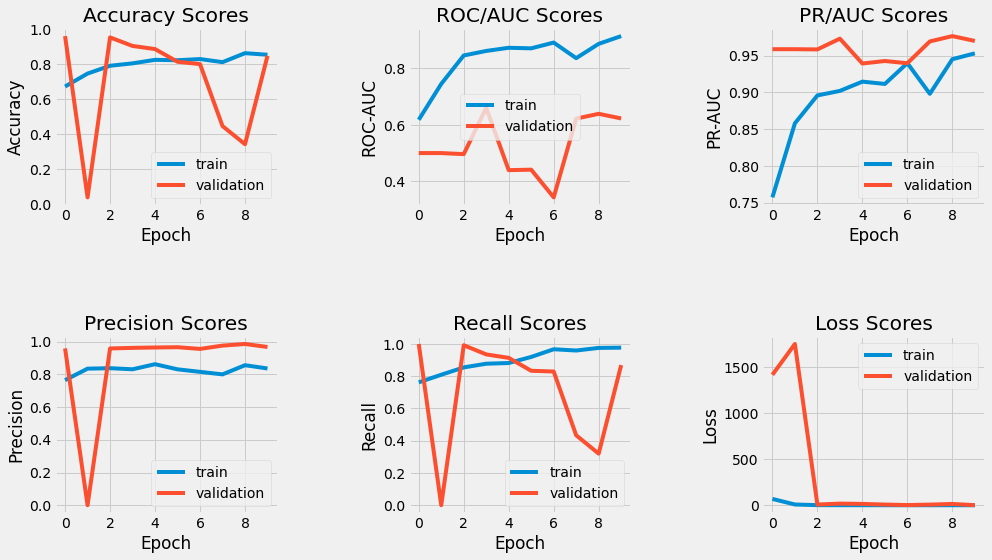

In [66]:
sixplot(history, 'auc_10', 'val_auc_10', 'auc_11', 'val_auc_11', 'precision_5', 'val_precision_5', 'recall_5', 'val_recall_5')

In [67]:
hist_df_1 = pd.DataFrame(history.history)
hist_df_1

,loss,accuracy,precision_5,recall_5,auc_10,auc_11,val_loss,val_accuracy,val_precision_5,val_recall_5,val_auc_10,val_auc_11
0,68.984970,0.671875,0.764516,0.762058,0.617997,0.757186,1416.784546,0.958702,0.958702,1.000000,0.500000,0.958702
1,8.377172,0.745536,0.834921,0.809231,0.744991,0.857917,1751.496338,0.041298,0.000000,0.000000,0.500000,0.958702
2,1.372153,0.789954,0.837748,0.854730,0.845784,0.895826,7.672554,0.951327,0.958395,0.992308,0.496154,0.958396
3,0.873495,0.803653,0.831126,0.877622,0.861842,0.901995,17.971416,0.902655,0.962025,0.935385,0.660220,0.973054
4,0.770518,0.823661,0.862179,0.881967,0.873048,0.914581,14.787459,0.884956,0.964286,0.913846,0.439423,0.939246
5,0.500786,0.821429,0.830816,0.919732,0.871103,0.911458,7.610707,0.812684,0.966132,0.833846,0.441126,0.942636
6,0.387336,0.828125,0.815427,0.967320,0.891536,0.939763,2.405735,0.799410,0.955674,0.829231,0.343049,0.939620
7,0.419102,0.810502,0.800000,0.959459,0.836303,0.898019,7.144781,0.446903,0.975779,0.433846,0.622115,0.969278
8,0.345916,0.861607,0.856000,0.975684,0.886963,0.945086,14.231954,0.343658,0.985782,0.320000,0.639066,0.976512
9,0.373089,0.852679,0.836111,0.977273,0.914437,0.953058,1.070862,0.846608,0.967466,0.869231,0.622665,0.969928


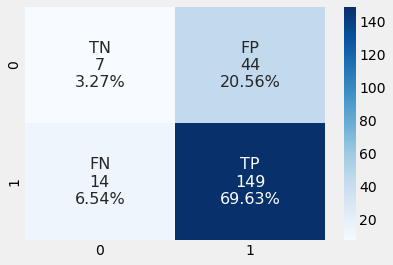

In [68]:
y_pred = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

- Accuracy is not useful for extremely imbalance datasets.  High Accuracy is easily achieved by just predicting majority class.
- Precision tells us how many of the correctly predicted cases actually turned out to be positive. 
- Recall tells us how many of the actual positive cases we were able to predict correctly with our model.  Recall is a useful metric in cases where False Negative trumps False Positive.
- 

# VGG16

In [39]:
vgg16 = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(224, 224, 3))

for layer in vgg16.layers:
    layer.trainable = False

input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model2 = Model(inputs=input_, outputs=last_layer)

model2.compile(optimizer = Adam(learning_rate=0.01), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])


In [41]:
filepath = '../models/CNN_v3.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history3 = model2.fit_generator(generator = datagen,
                                verbose = 1,
                                epochs = 20,
                                callbacks = [earlyStopping, mcp_save],
                                validation_data = val_generator,
                                steps_per_epoch = len(train_generator),
                                validation_steps = len(val_generator)) 

Epoch 1/20
14/14 [==============================] - 214s 16s/step - loss: 2.3746 - accuracy: 0.6548 - precision_3: 0.7153 - recall_3: 0.6959 - auc_6: 0.6812 - auc_7: 0.7649 - val_loss: 0.8371 - val_accuracy: 0.8776 - val_precision_3: 0.9595 - val_recall_3: 0.9108 - val_auc_6: 0.5680 - val_auc_7: 0.9649
Epoch 2/20
14/14 [==============================] - 231s 17s/step - loss: 0.5604 - accuracy: 0.8936 - precision_3: 0.9168 - recall_3: 0.9287 - auc_6: 0.9074 - auc_7: 0.9332 - val_loss: 0.8084 - val_accuracy: 0.8805 - val_precision_3: 0.9656 - val_recall_3: 0.9077 - val_auc_6: 0.6675 - val_auc_7: 0.9746
Epoch 3/20
14/14 [==============================] - 215s 16s/step - loss: 0.7909 - accuracy: 0.8567 - precision_3: 0.9037 - recall_3: 0.8882 - auc_6: 0.8953 - auc_7: 0.9285 - val_loss: 1.1012 - val_accuracy: 0.7817 - val_precision_3: 0.9736 - val_recall_3: 0.7938 - val_auc_6: 0.7539 - val_auc_7: 0.9849
Epoch 4/20
14/14 [==============================] - 232s 17s/step - loss: 0.5411 - accur

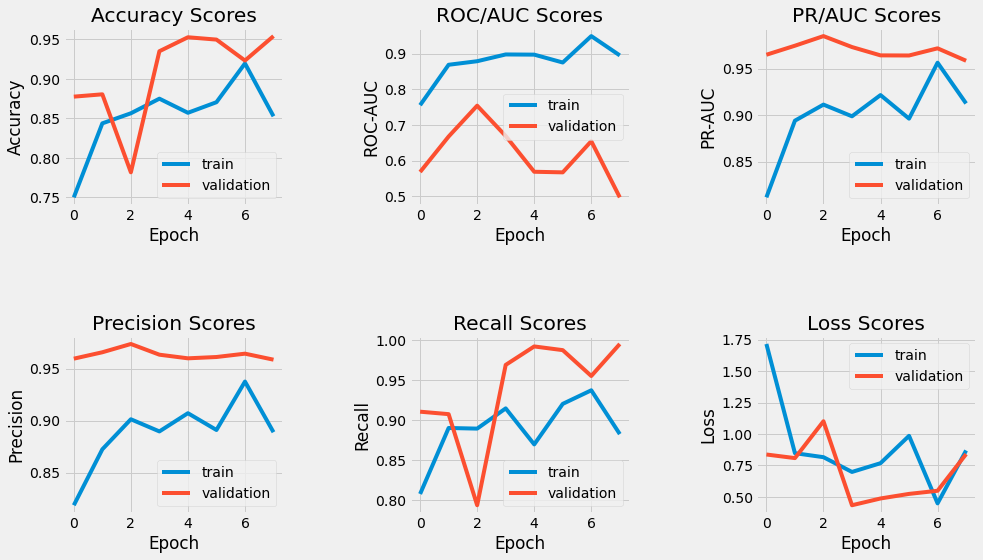

In [42]:
sixplot(history3, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

In [49]:
hist_df_2 = pd.DataFrame(history3.history)
hist_df_2

,loss,accuracy,precision_3,recall_3,auc_6,auc_7,val_loss,val_accuracy,val_precision_3,val_recall_3,val_auc_6,val_auc_7
0,1.715266,0.750000,0.818792,0.807947,0.755330,0.811751,0.837055,0.877581,0.959481,0.910769,0.568022,0.964906
1,0.847626,0.843750,0.872483,0.890411,0.868590,0.894093,0.808449,0.880531,0.965630,0.907692,0.667500,0.974601
2,0.815751,0.856502,0.901316,0.889610,0.878553,0.911363,1.101205,0.781711,0.973585,0.793846,0.753901,0.984922
3,0.698417,0.875000,0.889655,0.914894,0.897505,0.898803,0.433854,0.935103,0.963303,0.969231,0.668984,0.973168
4,0.767913,0.857143,0.907143,0.869863,0.896997,0.921591,0.487553,0.952802,0.959821,0.992308,0.568681,0.964229
5,0.985381,0.870536,0.891026,0.920530,0.874943,0.896293,0.524007,0.949853,0.961078,0.987692,0.567006,0.964106
6,0.448836,0.919643,0.937500,0.937500,0.948958,0.956368,0.548756,0.923304,0.964286,0.955385,0.654396,0.971795
7,0.869022,0.852679,0.888889,0.882759,0.894850,0.912589,0.840088,0.954277,0.958519,0.995385,0.496923,0.958458


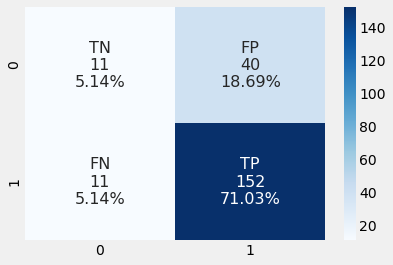

In [65]:
probabilities2 = model2.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities2 > 0.5
make_confusion_matrix(y_true, y_pred)